In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, BatchNormalization, Activation 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./input"))

import regex as re
import gc
# Any results you write to the current directory are saved as output.

['covertype_test.csv', 'covertype_test.csv.zip', 'covertype_train.csv', 'covertype_train.csv.zip', 'sample_submission.csv']


ImportError: No module named 'regex'

In [ ]:
baseline_tree_score = 0.23092278864723115
baseline_neuralnetwork_score = 0.5480561937041435

In [4]:
train = pd.read_csv('./input/covertype_train.csv')
test = pd.read_csv('./input/covertype_test.csv')

In [5]:
train_index = train.shape[0]

### Utility Function 입니다.

In [6]:
lgbm_param =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    "learning_rate": 0.06,
    "num_leaves": 16,
    "max_depth": 6,
    "colsample_bytree": 0.7,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "nthread":8
}

In [7]:
def keras_model(input_dims):
    model = Sequential()
    
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    # output layer (y_pred)
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # compile this model
    model.compile(loss='binary_crossentropy', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam', metrics=['accuracy'])
    return model

def keras_history_plot(history):
    plt.plot(history.history['loss'], 'y', label='train loss')
    plt.plot(history.history['val_loss'], 'r', label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

In [8]:
def baseline_tree_cv(train):
    train_df = train.copy()
    y_value = train_df["Cover_Type"]
    del train_df["Cover_Type"], train_df["ID"]
    
    NFOLD = 5
    folds = StratifiedKFold(n_splits= NFOLD, shuffle=True, random_state=2018)

    total_score = 0
    best_iteration = 0
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_value)):
        train_x, train_y = train_df.iloc[train_idx], y_value.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y_value.iloc[valid_idx]

        evals_result_dict = {} 
        dtrain = lgbm.Dataset(train_x, label=train_y)
        dvalid = lgbm.Dataset(valid_x, label=valid_y)

        clf = lgbm.train(lgbm_param, train_set=dtrain, num_boost_round=3000, valid_sets=[dtrain, dvalid],
                               early_stopping_rounds=200, evals_result=evals_result_dict, verbose_eval=500)

        predict = clf.predict(valid_x)
        cv_score = log_loss(valid_y, predict )
        total_score += cv_score
        best_iteration = max(best_iteration, clf.best_iteration)
        print('Fold {} LogLoss : {}'.format(n_fold + 1, cv_score ))
        lgbm.plot_metric(evals_result_dict)
        plt.show()
        
    print("Best Iteration", best_iteration)
    print("Total LogLoss", total_score / NFOLD)
    print("Baseline model Score Diff", total_score / NFOLD - baseline_tree_score)
    
    del train_df
    
    return best_iteration

def baseline_keras_cv(train):
    train_df = train.copy()
    y_value = train_df['Cover_Type']
    del train_df['Cover_Type'], train_df['ID']
    
    model = keras_model(train_df.shape[1])
    callbacks = [
            EarlyStopping(
                patience=10,
                verbose=10)
        ]

    NFOLD = 5
    folds = StratifiedKFold(n_splits= NFOLD, shuffle=True, random_state=2018)

    total_score = 0
    best_epoch = 0
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_value)):
        train_x, train_y = train_df.iloc[train_idx], y_value.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y_value.iloc[valid_idx]

        history = model.fit(train_x.values, train_y.values, nb_epoch=30, batch_size = 64, validation_data=(valid_x.values, valid_y.values), 
                            verbose=1, callbacks=callbacks)

        keras_history_plot(history)
        predict = model.predict(valid_x.values)
        null_count = np.sum(pd.isnull(predict) )
        if null_count > 0:
            print("Null Prediction Error: ", null_count)
            predict[pd.isnull(predict)] = predict[~pd.isnull(predict)].mean()

        cv_score = log_loss(valid_y, predict )
        total_score += cv_score
        best_epoch = max(best_epoch, np.max(history.epoch))
        print('Fold {} LogLoss : {}'.format(n_fold + 1, cv_score ))
        
    print("Best Epoch: ", best_epoch)
    print("Total LogLoss", total_score/NFOLD)
    print("Baseline model Score Diff", total_score/NFOLD - baseline_neuralnetwork_score)

# 이번 Kernel에서는 기본적인 Data 변환을 실습하도록 하겠습니다.

제가 설명하는동안 직접 코드 실행 시키시면서 이것저것 해보시는 것이 좋습니다!

### 값이 너무 큰 Elevation Feature Log Transform 수행

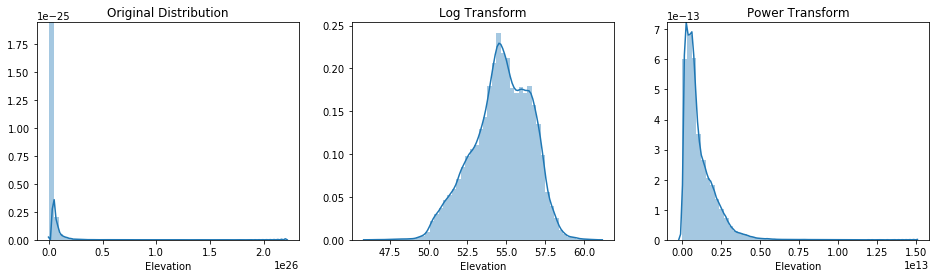

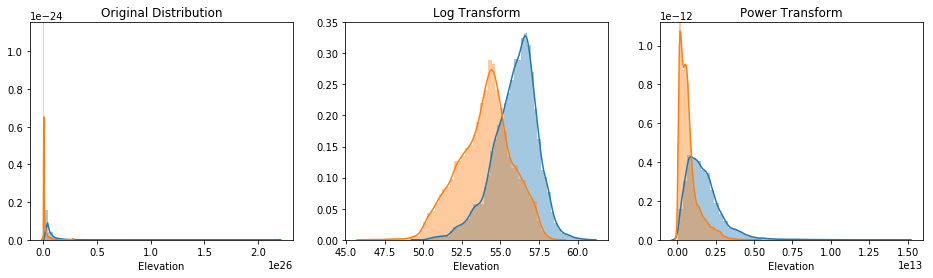

In [9]:
all_data = pd.concat([train,test])

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
sns.distplot(all_data['Elevation'],ax=axes[0])
sns.distplot(np.log1p(all_data['Elevation']),ax=axes[1])
sns.distplot(np.sqrt(all_data['Elevation']),ax=axes[2])
axes[0].set_title('Original Distribution')
axes[1].set_title('Log Transform')
axes[2].set_title('Power Transform')
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
sns.distplot(all_data.loc[all_data['Cover_Type']==0, 'Elevation'],ax=axes[0])
sns.distplot(all_data.loc[all_data['Cover_Type']==1, 'Elevation'],ax=axes[0])
sns.distplot(np.log1p(all_data.loc[all_data['Cover_Type']==0, 'Elevation']),ax=axes[1])
sns.distplot(np.log1p(all_data.loc[all_data['Cover_Type']==1, 'Elevation']),ax=axes[1])
sns.distplot(np.sqrt(all_data.loc[all_data['Cover_Type']==0, 'Elevation']),ax=axes[2])
sns.distplot(np.sqrt(all_data.loc[all_data['Cover_Type']==1, 'Elevation']),ax=axes[2])

axes[0].set_title('Original Distribution')
axes[1].set_title('Log Transform')
axes[2].set_title('Power Transform')
plt.show()

In [10]:
del all_data['oil_Type']
all_data['Elevation'] = np.log1p(all_data['Elevation'])

In [11]:
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

### Tree Model에서는 Log Trasnform 한다고 성능차이가 크지 않았습니다.

In [ ]:
baseline_tree_cv(train_df)

Training until validation scores don't improve for 200 rounds.


### 같은 Feature를 NeuralNetwork에 적용해 보도록 하겠습니다.

In [ ]:
all_data = pd.concat([train,test])

del all_data['oil_Type']
all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

In [ ]:
baseline_keras_cv(train_df)

## Neural Network에서는 아주 큰 값에 Log Transform 하였을 때 많이 개선된 것을 볼 수 있습니다.

## EDA 할 때 Numerical Data에 아주 큰 값이 들어 있는 것을 또 볼 수 있었습니다.

In [ ]:
all_data = pd.concat([train,test])

del all_data['oil_Type']
all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

In [ ]:
for col in numerical_feature:
    sns.distplot(all_data.loc[all_data[col].notnull(), col])
    plt.title(col)
    plt.show()

### 아래 2개의 Feature가 이상합니다.

In [ ]:
['Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways']

### Graph가 어느 순간에 꺽이는 것을 볼 수 있습니다.

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(np.sort(all_data['Horizontal_Distance_To_Fire_Points']))
axes[1].plot(np.cumsum(np.sort(all_data['Horizontal_Distance_To_Fire_Points'])))
plt.title('Horizontal_Distance_To_Fire_Points')
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(np.sort(all_data['Horizontal_Distance_To_Roadways']))
axes[1].plot(np.cumsum(np.sort(all_data['Horizontal_Distance_To_Roadways'])))
plt.title('Horizontal_Distance_To_Roadways')
plt.show()

In [ ]:
for percent in np.arange(99,100,0.1):
    print(np.percentile(all_data['Horizontal_Distance_To_Fire_Points'],percent))

In [ ]:
for percent in np.arange(99,100,0.1):
    print(np.percentile(all_data['Horizontal_Distance_To_Roadways'],percent))

In [ ]:
def outlier_binary(frame, col, outlier_range):
    outlier_feature = col + '_Outlier'
    frame[outlier_feature] = 0
    frame.loc[frame[col] > outlier_range, outlier_feature] = 1
    return frame

In [ ]:
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

In [ ]:
all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

In [ ]:
baseline_keras_cv(train_df)

## 뭔가 이렇게만 outlier binary feature 하나로만은 좀 아쉽습니다.
좀 더 살펴보도록 하겠습니다.

### Horizontal_Distance_To_Roadways의 분포를 다시한번 살펴봅니다.
자세히 보니 큰 값과 작은 값의 분포가 거의 비슷합니다.<br>
큰 값의 중앙값과 작은 값의 중앙값의 비율로 큰 값을 나눠 줍니다.<br>

In [ ]:
all_data = pd.concat([train, test])
hdroad_outlier_index = all_data['Horizontal_Distance_To_Roadways']>=10000

sns.distplot(all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'])
plt.show()

hdroad_outlier_median =  all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'].median()
hdroad_normal_median = all_data.loc[all_data['Horizontal_Distance_To_Roadways']<10000, 'Horizontal_Distance_To_Roadways'].median()
print(hdroad_outlier_median, hdroad_normal_median, hdroad_outlier_median/hdroad_normal_median)
hdroad_outlier_ratio = hdroad_outlier_median/hdroad_normal_median

sns.distplot(all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways']/hdroad_outlier_ratio)
plt.show()

### Horizontal_Distance_To_Roadways 분포를 다시 그려보니 큰 값이 모두 제거 되었습니다.
Target값도 둘 사이의 분포가 달라서 Algorithm 성능이 좋게 나올 것 같습니다.

In [ ]:
all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'] = all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways']/hdroad_outlier_ratio
sns.distplot(all_data['Horizontal_Distance_To_Roadways'])
plt.show()
sns.distplot(all_data.loc[all_data['Cover_Type']==0,'Horizontal_Distance_To_Roadways'])
sns.distplot(all_data.loc[all_data['Cover_Type']==1,'Horizontal_Distance_To_Roadways'])
plt.show()

### 마찬가지로 Horizontal_Distance_To_Fire_Points 도 살펴봅니다.

In [ ]:
all_data = pd.concat([train, test])
hdfpoint_outlier_index = all_data['Horizontal_Distance_To_Fire_Points']>=10000

sns.distplot(all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'])
plt.show()

hdfpoint_outlier_median =  all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'].median()
hdfpoint_normal_median = all_data.loc[all_data['Horizontal_Distance_To_Fire_Points']<10000, 'Horizontal_Distance_To_Fire_Points'].median()
print(hdfpoint_outlier_median, hdfpoint_normal_median, hdfpoint_outlier_median/hdfpoint_normal_median)
hdfpoint_outlier_ratio = hdfpoint_outlier_median/hdfpoint_normal_median

sns.distplot(all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points']/hdfpoint_outlier_ratio)
plt.show()

In [ ]:
all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'] = all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points']/hdfpoint_outlier_ratio
sns.distplot(all_data['Horizontal_Distance_To_Fire_Points'])
plt.show()
sns.distplot(all_data.loc[all_data['Cover_Type']==0,'Horizontal_Distance_To_Fire_Points'])
sns.distplot(all_data.loc[all_data['Cover_Type']==1,'Horizontal_Distance_To_Fire_Points'])
plt.show()

In [ ]:
def outlier_divide_ratio(frame, col, outlier_range):
    outlier_index = frame[col] >= outlier_range
    outlier_median =  frame.loc[outlier_index, col].median()
    normal_median = frame.loc[frame[col] < outlier_range, col].median()
    outlier_ratio = outlier_median / normal_median
    
    frame.loc[outlier_index, col] = frame.loc[outlier_index, col]/outlier_ratio
    return frame

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)

numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

baseline_keras_cv(train_df)

## Neural Network는 One Hot Encoding으로 성능이 올라갈까?
Neural Network Model은 Category Feature를 그대로 사용하면(Label Encoding) 성능이 안좋다고 합니다.<br>
같은 차원에서 데이터를 나눌 수 없어 독립된 다른 차원으로 보내야 한다고 합니다.<br>
그래서 흔히 사용하는 방법이 One Hot Encoding과 Entity Embedding 방법입니다. <br>
One Hot Encoding은 차원이 아주 많아지는 단점이 있고 Category간의 유사성을 파악하기 힘듭니다.<br>
요새 나온 우승자 솔루션들 보면 거의 Entity Embedding을 사용하고 있습니다.<br>
One Hot과 Entity Embedding의 성능을 비교해보는 것이 좋은데, 그것은 제가 이번에 준비하지 못해서 공부할 수 있는 Link만 걸어드릴게요<br>
꼭 사용해보세요<br>
https://www.kaggle.com/youhanlee/simple-eda-entity-embedding - 이유한님 Kernel<br>
https://www.kaggle.com/aquatic/entity-embedding-neural-net - Joe Eddy Kaggle Kernel<br>
https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9 - 위 Kaggle Kernel을 설명한 <br>
https://github.com/entron/entity-embedding-rossmann <br>
http://www.fast.ai/2018/04/29/categorical-embeddings/ <br>
https://arxiv.org/abs/1604.06737 <br>

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data = pd.concat([all_data,pd.get_dummies(all_data[col],prefix=col)],axis=1)
    category_feature.append(col)
    del all_data[col]
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

baseline_keras_cv(train_df)

## 알려진대로 NeuralNetwork는 OneHot을 해야합니다
## 성능이 꽤 많이 올라가서 기분이 좋네요

## 아까 mean으로 채운 NULL 값을 제대로 채워볼까요?
문제를 변환해서 Aspect 값의 NULL 값을 Test로 놓고 값이 있는 것을 Train으로 놓습니다.<br>
KNN을 사용하여 Aspect 값을 채워보도록 하겠습니다. <br>

코드가 좀 긴데 잘 따라와주세요~<br>
아래는 까지는 기본 Feature 추가한 것입니다.

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data = pd.concat([all_data,pd.get_dummies(all_data[col],prefix=col)],axis=1)
    category_feature.append(col)
    del all_data[col]
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

In [ ]:
all_data['Aspect'].isnull().sum()

Aspect 값이 Null인 것은 Test, Null이 아닌 것은 Train으로 놓습니다. 그리고 Cover_Type과 ID값은 지워줍니다.

In [ ]:
aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

KNN은 거리기반 알고리즘이기 때문에 Scale에 민감합니다. Aspect 값을 제외하고 모두 StandardScale을 해줍니다.

In [ ]:
numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

그 후 Train, Test Set을 준비하는 것처럼 y값을 따로 빼주고 Aspect Column을 제거합니다.

In [ ]:
y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

Sklearn에 KNeighborsRegressor 을 불러와서 알고리즘을 실행합니다. K값은 Tuning이 필요한데요.<br>
CV 값을 보고 하여습니다. 여기서는 하드하게 튜닝하지 않고 적당히 하고 넘어가도록 하겠습니다. <br>

In [ ]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

predict와 원래 값의 분포를 보면 거의 비슷하게 Impuation 된것을 볼 수 있습니다. predict값을 원래 데이터에 넣고 성능을 측정해봅니다.

In [ ]:
sns.distplot(predict)
sns.distplot(all_data['Aspect'].dropna())
plt.show()

In [ ]:
all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

In [ ]:
baseline_keras_cv(train_df)

# 지금까지 정제한 Feature로 Tree Model에도 사용해보도록 하겠습니다.
tree 모델엔 One Hot을 사용하지 않고 Label Encoding만 해주도록 하겠습니다.

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

baseline_tree_cv(train_df)

## CategoryData를 Frequency Encoding 해볼게요
Category Data는 2개가 있습니다.

In [ ]:
category_feature

In [ ]:
all_data = pd.concat([train_df, test_df])

In [ ]:
soil_freq_encoding = all_data.groupby(['Soil_Type']).size()/all_data.shape[0]
soil_freq_encoding = soil_freq_encoding.reset_index().rename(columns={0:'Soil_Frequncy'})
all_data = all_data.merge(soil_freq_encoding, on='Soil_Type', how='left')

In [ ]:
def frequency_encoding(frame, col):
    freq_encoding = frame.groupby([col]).size()/all_data.shape[0] 
    freq_encoding = freq_encoding.reset_index().rename(columns={0:'{}_Frequncy'.format(col)})
    return frame.merge(freq_encoding, on=col, how='left')

In [ ]:
all_data = frequency_encoding(all_data, 'Wilderness_Area')

In [ ]:
train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

In [ ]:
frequency_df = train_df.groupby(['Soil_Frequncy','Cover_Type'])['Soil_Frequncy'].count().unstack('Cover_Type')
frequency_df.plot(kind='bar', figsize=(14,5))
plt.title('SoilType Frequency')
plt.show()

In [ ]:
frequency_df = train_df.groupby(['Wilderness_Area_Frequncy','Cover_Type'])['Wilderness_Area_Frequncy'].count().unstack('Cover_Type')
frequency_df.plot(kind='bar', figsize=(10,5))
plt.title('Wilderness_Area_Frequncy')
plt.show()

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = frequency_encoding(all_data, 'Soil_Type')
all_data = frequency_encoding(all_data, 'Wilderness_Area')

aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

sns.distplot(predict)
sns.distplot(all_data['Aspect'].dropna())
plt.show()

all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

baseline_tree_cv(train_df)